In [1]:
import argparse
import numpy as np
import sys, os
import torch
import time
import h5py
import torch.nn as nn
from sklearn import decomposition

#import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from utils import prf_utils, torch_utils, texture_utils, default_paths
from model_fitting import initialize_fitting
from model_src import sketch_token_features

device = initialize_fitting.init_cuda()


#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
subject = 1
debug=True
use_node_storage=False

if use_node_storage:
    sketch_token_feat_path = default_paths.sketch_token_feat_path_localnode
else:
    sketch_token_feat_path = default_paths.sketch_token_feat_path

# Params for the spatial aspect of the model (possible pRFs)
aperture = 1.0
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

# Fix these params
map_resolution = 227  
n_prf_sd_out = 2
batch_size = 100
mult_patch_by_prf = True
do_avg_pool = True

features_file = os.path.join(sketch_token_feat_path, 'S%d_features_%d.h5py'%(subject, map_resolution))
if not os.path.exists(features_file):
    raise RuntimeError('Looking at %s for precomputed features, not found.'%features_file)

# features_each_prf = sketch_token_features.get_features_each_prf(features_file, models, mult_patch_by_prf=mult_patch_by_prf, \
#                                                                 do_avg_pool=do_avg_pool, batch_size=batch_size, aperture=aperture, \
#                                                                 debug=debug, device=device)


most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [50]:
# def get_features_each_prf(features_file, models, mult_patch_by_prf=True, do_avg_pool=True, \
#                           batch_size=100, aperture=1.0, debug=False, device=None):
#     """
#     Extract the portion of the feature maps corresponding to each prf in 'models'
#     Start with loading the feature maps h5py file (generated by get_st_features.m)
#     Save smaller features as an h5py file [n_images x n_features x n_prfs]
#     """


if device is None:
    device = 'cpu:0'

with h5py.File(features_file, 'r') as data_set:
    ds_size = data_set['/features'].shape
n_images = ds_size[3]
n_features = ds_size[0]
map_resolution = ds_size[1]
n_prfs = models.shape[0]
features_each_prf = np.zeros((n_images, n_features, n_prfs))
n_batches = int(np.ceil(n_images/batch_size))

bb=0
# for bb in range(n_batches):

#     if debug and bb>9:
#         continue

batch_inds = np.arange(batch_size * bb, np.min([batch_size * (bb+1), n_images]))

print('Loading features for images [%d - %d]'%(batch_inds[0], batch_inds[-1]))
st = time.time()
with h5py.File(features_file, 'r') as data_set:
    # Note this order is reversed from how it was saved in matlab originally.
    # The dimensions go [features x h x w x images]
    # Luckily h and w are swapped matlab to python anyway, so can just switch the first and last.
    values = np.copy(data_set['/features'][:,:,:,batch_inds])
    data_set.close()  
fmaps_batch = np.moveaxis(values, [0,1,2,3],[3,1,2,0])

elapsed = time.time() - st
print('Took %.5f sec to load feature maps'%elapsed)

maps_full_field = torch_utils._to_torch(fmaps_batch, device=device)

# mm=100

for mm in range(n_prfs):

    if debug and mm>9:
        continue

    prf_params = models[mm,:]
    x,y,sigma = prf_params
    print('Getting features for pRF [x,y,sigma]:')
    print([x,y,sigma])
    n_pix = map_resolution

     # Define the RF for this "model" version
    prf = torch_utils._to_torch(prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                              dtype=np.float32)[2], device=device)
    minval = torch.min(prf)
    maxval = torch.max(prf-minval)
    prf_scaled = (prf - minval)/maxval

    if mult_patch_by_prf:         
        # This effectively restricts the spatial location, so no need to crop
        maps = maps_full_field * prf_scaled.view([1,map_resolution,map_resolution,1])
    else:
        # This is a coarser way of choosing which spatial region to look at
        # Crop the patch +/- n SD away from center
        n_pf_sd_out = 2
        bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out, min_pix=None, verbose=False, force_square=False)
        print('bbox to crop is:')
        print(bbox)
        maps = maps_full_field[:,bbox[0]:bbox[1], bbox[2]:bbox[3],:]

    if do_avg_pool:
        features_batch = torch.mean(maps, dim=(1,2))
    else:
        features_batch = torch.max(maps, dim=(1,2))

    print('model %d, min/max of features in batch: [%s, %s]'%(mm, torch.min(features_batch), torch.max(features_batch)))    
    
    features_each_prf[batch_inds,:,mm] = torch_utils.get_value(features_batch)

#     return features_each_prf

Loading features for images [0 - 99]
Took 44.83579 sec to load feature maps
Getting features for pRF [x,y,sigma]:
[-0.55, -0.55, 0.03999999910593033]
model 0, min/max of features in batch: [tensor(0., device='cuda:0'), tensor(0.0006, device='cuda:0')]
Getting features for pRF [x,y,sigma]:
[-0.49210526315789477, -0.55, 0.03999999910593033]
model 1, min/max of features in batch: [tensor(9.8091e-45, device='cuda:0'), tensor(0.0014, device='cuda:0')]
Getting features for pRF [x,y,sigma]:
[-0.4342105263157895, -0.55, 0.03999999910593033]
model 2, min/max of features in batch: [tensor(1.1743e-39, device='cuda:0'), tensor(0.0023, device='cuda:0')]
Getting features for pRF [x,y,sigma]:
[-0.37631578947368427, -0.55, 0.03999999910593033]
model 3, min/max of features in batch: [tensor(2.7010e-35, device='cuda:0'), tensor(0.0024, device='cuda:0')]
Getting features for pRF [x,y,sigma]:
[-0.31842105263157894, -0.55, 0.03999999910593033]
model 4, min/max of features in batch: [tensor(9.3799e-32, devi

In [52]:
features_each_prf[80,0,0:20]

array([1.02180343e-06, 5.15749707e-06, 1.09899984e-05, 5.19005789e-06,
       2.09315090e-06, 3.40674296e-06, 7.54106895e-06, 1.11403560e-05,
       4.06847312e-06, 1.24830694e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [44]:
feat_file_prf = os.path.join(sketch_token_feat_path, 'S%d_features_each_prf.h5py'%(subject))

print('Loading pre-computed features from %s'%feat_file_prf)
t = time.time()
with h5py.File(feat_file_prf , 'r') as data_set:
    values = np.copy(data_set['/features'])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf.h5py
Took 12.31573 seconds to load file


In [45]:
values[80,0,0:20]

array([3.59191926e-10, 1.12072420e-13, 4.69240338e-17, 4.46728018e-21,
       2.10626262e-26, 2.03826533e-33, 1.23412356e-41, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

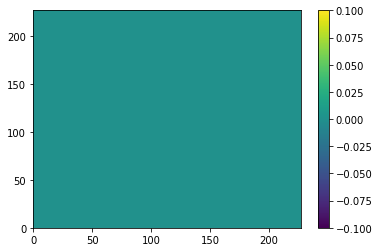

In [47]:
import matplotlib.pyplot as plt
plt.figure;
plt.pcolormesh(maps[0,:,:,0].detach().cpu().numpy())
plt.colorbar()

In [38]:
n_prfs

875

In [37]:
features_batch

tensor([[3.0108e-09, 1.0483e-08, 3.0167e-09,  ..., 2.7163e-09, 4.7481e-09,
         9.0530e-07],
        [1.1689e-09, 1.4440e-08, 1.3443e-09,  ..., 1.2871e-09, 1.0683e-09,
         1.1314e-06],
        [1.4814e-09, 1.6539e-08, 3.2850e-09,  ..., 1.6707e-09, 2.7412e-09,
         1.0478e-06],
        ...,
        [8.8905e-10, 2.2478e-08, 1.5049e-09,  ..., 1.1234e-09, 1.6206e-09,
         9.2195e-07],
        [2.4654e-09, 8.5751e-09, 1.9984e-09,  ..., 2.3570e-09, 7.2511e-10,
         1.5273e-06],
        [8.0330e-09, 2.4378e-09, 8.6143e-09,  ..., 7.3204e-09, 7.0904e-09,
         1.1114e-06]], device='cuda:0')

In [3]:
features_each_prf.shape

(10000, 151, 875)

In [7]:
features_each_prf[180,:,1]

array([7.17398485e-14, 1.87735136e-13, 5.26547020e-14, 8.51459067e-14,
       1.45343603e-13, 8.76250976e-14, 1.12499819e-13, 1.01929221e-13,
       5.08382466e-14, 5.66156924e-14, 1.24116917e-13, 8.29613545e-14,
       8.41201024e-14, 5.89889194e-14, 1.42404873e-13, 5.47483981e-14,
       7.07647713e-14, 6.91092149e-14, 4.32738223e-14, 6.93613190e-14,
       9.61521512e-14, 9.71350685e-14, 5.98992969e-14, 3.68655674e-14,
       6.42017906e-14, 6.58277347e-14, 9.08976331e-14, 6.54163816e-14,
       9.66841692e-14, 8.09418450e-14, 4.18362244e-14, 6.26327874e-14,
       2.12209021e-13, 2.53329411e-14, 6.56831902e-14, 5.96269833e-13,
       5.29682906e-14, 1.00641521e-13, 6.96267114e-14, 1.32328298e-13,
       1.18361511e-13, 2.93142213e-14, 3.98318531e-14, 4.13481031e-14,
       9.17461772e-14, 1.60728608e-13, 4.01620401e-14, 7.64827316e-14,
       5.36711958e-14, 4.22129610e-14, 3.65256836e-14, 5.86777534e-13,
       4.33506583e-14, 1.45002093e-13, 5.42896823e-14, 5.98664727e-14,
      

In [36]:
values.shape
np.where(values[9000,83,:]>0)

(array([0, 1, 2, 3, 4, 5, 6]),)

In [4]:
fn2save = os.path.join(sketch_token_feat_path, 'S%d_features_each_prf_TESTDEBUG.h5py'%(subject))

print('Writing prf features to %s\n'%fn2save)

t = time.time()
with h5py.File(fn2save, 'w') as data_set:
    dset = data_set.create_dataset("features", np.shape(features_each_prf), dtype=np.float64)
    data_set['/features'][:,:,:] = features_each_prf
    data_set.close()  
elapsed = time.time() - t

print('Took %.5f sec to write file'%elapsed)

Writing prf features to /user_data/mmhender/features/sketch_tokens/S1_features_each_prf_TESTDEBUG.h5py

Took 14.38785 sec to write file


In [8]:
print('Loading pre-computed features from %s'%fn2save)
t = time.time()
with h5py.File(fn2save, 'r') as data_set:
    values = np.copy(data_set['/features'])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf_TESTDEBUG.h5py
Took 8.77678 seconds to load file


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
np.all(values==features_each_prf)

True

In [77]:
# image_inds = image_order_trn[0:10]
image_inds = image_order_val[0:10]

In [78]:
image_inds

array([625, 665, 611, 435, 726,  39, 435,  59, 969, 478], dtype=uint16)

(0.0, 227.0, 227.0, 0.0)

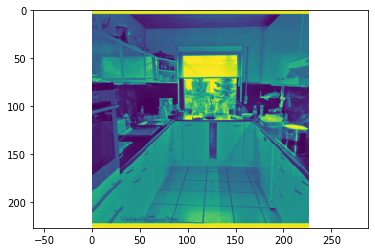

In [79]:
import matplotlib.pyplot as plt
ii=3
# im = trn_stim_data[ii,0,:,:]
im = val_stim_data[ii,0,:,:]
plt.figure;
plt.pcolormesh(im)
plt.gca().invert_yaxis()
plt.axis('equal')

In [80]:
features_file = os.path.join(sketch_token_feat_path, 'S%d_features_%d.h5py'%(subject, map_resolution))

In [81]:
with h5py.File(features_file, 'r') as data_set:
    # Note this order is reversed from how it was saved in matlab originally.
    # The dimensions go [features x h x w x images]
    # Luckily h and w are swapped matlab to python anyway, so can just switch the first and last.
#     values = np.copy(data_set['/features'][:,:,:,image_order_trn[ii:ii+1]])
    values = np.copy(data_set['/features'][:,:,:,image_order_val[ii:ii+1]])
    data_set.close()  

(0.0, 227.0, 227.0, 0.0)

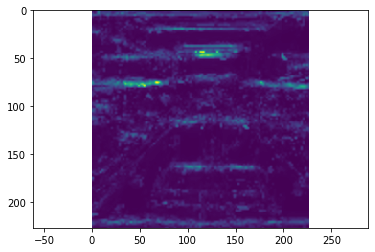

In [82]:
ff=1
im =values[ff,:,:,0]
plt.figure;
plt.pcolormesh(im)
plt.gca().invert_yaxis()
plt.axis('equal')

In [86]:
fmaps_batch = np.moveaxis(values, [0,1,2,3],[3,1,2,0])
maps = torch_utils._to_torch(fmaps_batch, device=device)
mm=700
prf_params = models[mm,:]
x,y,sigma = prf_params
print('Getting features for pRF [x,y,sigma]:')
print([x,y,sigma])
n_pix = map_resolution

# Define the RF for this "model" version
prf = torch_utils._to_torch(prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                          dtype=np.float32)[2], device=device)
minval = torch.min(prf)
maxval = torch.max(prf-minval)
prf_scaled = (prf - minval)/maxval

if mult_patch_by_prf:         
    # This effectively restricts the spatial location, so no need to crop
    maps = maps * prf.view([1,map_resolution,map_resolution,1])
else:
    # This is a coarser way of choosing which spatial region to look at
    # Crop the patch +/- n SD away from center
    n_pf_sd_out = 2
    bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out, min_pix=None, verbose=False, force_square=False)
    print('bbox to crop is:')
    print(bbox)
    maps = maps[:,bbox[0]:bbox[1], bbox[2]:bbox[3],:]

if do_avg_pool:
    features_batch = torch.mean(maps, dim=(1,2))
else:
    features_batch = torch.max(maps, dim=(1,2))


Getting features for pRF [x,y,sigma]:
[0.44000000000000006, 0.1100000000000001, 0.07722790539264679]


In [87]:
features_batch

tensor([[2.5084e-08, 8.3787e-08, 2.6982e-08, 3.0061e-08, 6.6465e-08, 3.1967e-08,
         3.0632e-08, 6.1117e-08, 3.4326e-08, 5.6241e-08, 3.8378e-08, 3.7624e-08,
         3.3135e-08, 7.6697e-08, 8.1088e-08, 5.6090e-08, 3.2526e-08, 1.9789e-08,
         5.5300e-08, 4.0138e-08, 3.9244e-08, 3.9851e-08, 4.4386e-08, 5.7707e-08,
         3.8185e-08, 6.8552e-08, 9.0714e-08, 2.6258e-08, 3.5155e-08, 4.8815e-08,
         2.2810e-08, 3.3778e-08, 8.8922e-08, 2.2937e-08, 1.5961e-08, 8.8925e-08,
         7.1439e-08, 5.7767e-08, 3.4152e-08, 3.2139e-08, 9.7914e-08, 6.0379e-08,
         4.2862e-08, 6.8289e-08, 3.3303e-08, 3.6148e-08, 3.6948e-08, 4.7925e-08,
         4.8759e-08, 7.1814e-08, 5.7240e-08, 8.6815e-08, 4.9040e-08, 6.1323e-08,
         2.9990e-08, 6.4129e-08, 7.7079e-08, 2.8791e-08, 3.8741e-08, 1.1704e-07,
         1.3256e-07, 7.6882e-08, 4.5405e-08, 1.1790e-07, 3.1171e-08, 1.9387e-08,
         2.8089e-08, 9.5582e-08, 1.0440e-07, 9.8455e-08, 5.1649e-08, 3.8970e-08,
         4.3427e-08, 2.0842e

In [88]:
feat_file_prf = os.path.join(sketch_token_feat_path, 'S%d_features_each_prf.h5py'%(subject))

print('Loading pre-computed features from %s'%feat_file_prf)
t = time.time()
with h5py.File(feat_file_prf , 'r') as data_set:
    values = np.copy(data_set['/features'])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)

# features_each_prf = values[image_inds,:,:]

Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf.h5py
Took 12.65659 seconds to load file


In [96]:
# values[0,0,:]

In [26]:

# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from model_src import fwrf_fit as fwrf_fit
from model_src import fwrf_predict as fwrf_predict
from model_src import texture_statistics_gabor, texture_statistics_pyramid, bdcn_features, sketch_token_features
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting, merge_features, arg_parser

fpX = np.float32
device = initialize_fitting.init_cuda()

fitting_type='sketch_tokens'
do_avg_pool=True
subject=1
volume_space = True
up_to_sess = 1
n_ori = 4
n_sf = 4
nonlin_fn = False
padding_mode = 'circular';
group_all_hl_feats = True; \
sample_batch_size = 50; voxel_batch_size = 100; \
zscore_features = True; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; do_val = True; do_varpart = True; date_str = None;
shuff_rnd_seed = 0; debug = True; \
do_pca = False; min_pct_var = 99; max_pc_to_retain = 400; map_ind = -1; \
n_prf_sd_out = 2; mult_patch_by_prf = True; \
downsample_factor = 1.0; do_nms = False

# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, volume_space)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, sessions=sessions, \
                                                                     voxel_mask=voxel_mask, volume_space=volume_space, \
                                                                      zscore_betas_within_sess=zscore_betas_within_sess, \
                                                                      shuffle_images=shuffle_images, random_images=random_images, \
                                                                                         random_voxel_data=random_voxel_data)


#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32

Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v